In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys

if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [4]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [57]:
last_date = '2022-06-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World'].query(f'date < "{last_date}"')

syn_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/syn_clade_stats_SARS_CoV_2/'
assert os.path.exists(syn_clade_stats_SARS_CoV_2_folder)

syn_clade_statistics_SARS_CoV_2_World = pd.read_csv(syn_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
syn_clade_statistics_SARS_CoV_2_World = syn_clade_statistics_SARS_CoV_2_World.query(f'Time < "{last_date}"')

In [119]:
nonsyn_all_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_all_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_all_clade_stats_SARS_CoV_2_folder)

nonsyn_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_all_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_clade_statistics_SARS_CoV_2_World = nonsyn_clade_statistics_SARS_CoV_2_World.query(f'Time < "{last_date}"')


In [120]:
nonsyn_S_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_S_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_S_clade_stats_SARS_CoV_2_folder)

nonsyn_S_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_S_clade_statistics_SARS_CoV_2_World = nonsyn_S_clade_statistics_SARS_CoV_2_World.query(f'Time < "{last_date}"')

In [121]:
syn_x_origination_times = []
nonsyn_all_x_origination_times = []
nonsyn_S_x_origination_times = []

xmin_vals =[0]+ list(np.logspace(-7,0,20))
for xmin in tqdm(xmin_vals ):
    syn_x_mini_df  = syn_clade_statistics_SARS_CoV_2_World.query(f'Sublineage_Freq > {xmin}').groupby(['Clade'])['Time'].min()
    syn_x_origination_times.append(syn_x_mini_df)

    nonsyn_all_mini_df = nonsyn_clade_statistics_SARS_CoV_2_World.query(f'Sublineage_Freq > {xmin}').groupby(['Clade'])['Time'].min()
    nonsyn_all_x_origination_times.append(nonsyn_all_mini_df)

    nonsyn_S_mini_df = nonsyn_S_clade_statistics_SARS_CoV_2_World.query(f'Sublineage_Freq > {xmin}').groupby(['Clade'])['Time'].min()
    nonsyn_S_x_origination_times.append(nonsyn_S_mini_df)

# concatenate with column names time_xmin
syn_x_origination_times = pd.concat(syn_x_origination_times,axis=1)
syn_x_origination_times.columns = [f'time_{xmin:.1e}' for xmin in xmin_vals]

nonsyn_all_x_origination_times = pd.concat(nonsyn_all_x_origination_times,axis=1)
nonsyn_all_x_origination_times.columns = [f'time_{xmin:.1e}' for xmin in xmin_vals]

nonsyn_S_x_origination_times = pd.concat(nonsyn_S_x_origination_times,axis=1)
nonsyn_S_x_origination_times.columns = [f'time_{xmin:.1e}' for xmin in xmin_vals]


100%|██████████| 21/21 [01:12<00:00,  3.47s/it]


In [122]:
reference_date = pd.to_datetime('2020-01-01')
syn_x_origination_times.reset_index(inplace=True)
nonsyn_all_x_origination_times.reset_index(inplace=True)
nonsyn_S_x_origination_times.reset_index(inplace=True)

for xmin in xmin_vals:
    syn_x_origination_times[f'Time_datetime_{xmin:.1e}'] = pd.to_datetime(syn_x_origination_times[f'time_{xmin:.1e}'])
    syn_x_origination_times[f'day_diff_{xmin:.1e}'] = syn_x_origination_times[f'Time_datetime_{xmin:.1e}']-reference_date
   
    nonsyn_all_x_origination_times[f'Time_datetime_{xmin:.1e}'] = pd.to_datetime(nonsyn_all_x_origination_times[f'time_{xmin:.1e}'])
    nonsyn_all_x_origination_times[f'day_diff_{xmin:.1e}'] = nonsyn_all_x_origination_times[f'Time_datetime_{xmin:.1e}']-reference_date

    nonsyn_S_x_origination_times[f'Time_datetime_{xmin:.1e}'] = pd.to_datetime(nonsyn_S_x_origination_times[f'time_{xmin:.1e}'])
    nonsyn_S_x_origination_times[f'day_diff_{xmin:.1e}'] = nonsyn_S_x_origination_times[f'Time_datetime_{xmin:.1e}']-reference_date

In [153]:
syn_count_thresh = []
nonsyn_all_count_thresh = []
nonsyn_S_count_thresh = []

for xmin in xmin_vals:
    dcol = syn_x_origination_times[f'day_diff_{xmin:.1e}']
    syn_count_thresh.append(dcol[~np.isnan(dcol)].count())

    dcol = nonsyn_all_x_origination_times[f'day_diff_{xmin:.1e}']
    nonsyn_all_count_thresh.append(dcol[~np.isnan(dcol)].count())

    dcol = nonsyn_S_x_origination_times[f'day_diff_{xmin:.1e}']
    nonsyn_S_count_thresh.append(dcol[~np.isnan(dcol)].count())

syn_count_thresh = np.array(syn_count_thresh)
nonsyn_all_count_thresh = np.array(nonsyn_all_count_thresh)
nonsyn_S_count_thresh = np.array(nonsyn_S_count_thresh)


In [161]:
sns.set_style("whitegrid")

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_2408/525270486.py:4: RuntimeWarning: divide by zero encountered in divide
  ax[0].plot(xmin_vals,5/xmin_vals * xmin_vals[-1]* syn_count_thresh[-1]/syn_count_thresh[0],'g:')


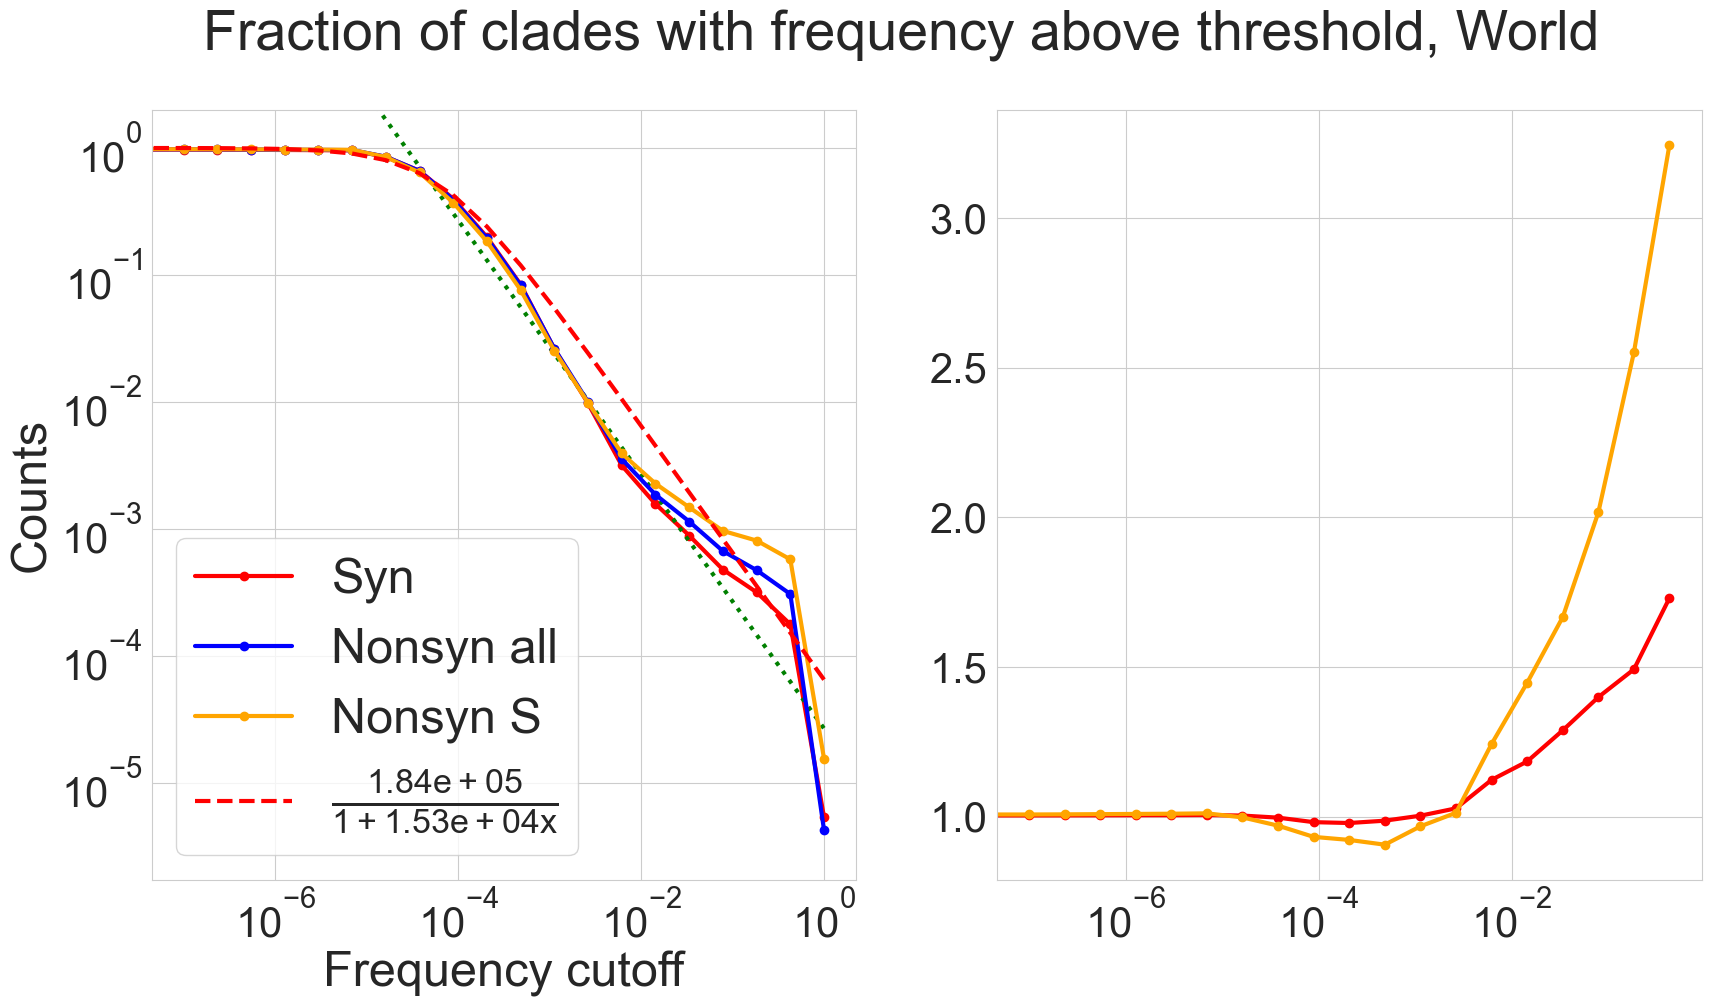

In [166]:
xmin_vals = np.array(xmin_vals)
fig,ax= plt.subplots(1,2,figsize=(20,10))
ax[0].plot(xmin_vals,syn_count_thresh/syn_count_thresh[0],marker='o',color='r',label='Syn')
ax[0].plot(xmin_vals,5/xmin_vals * xmin_vals[-1]* syn_count_thresh[-1]/syn_count_thresh[0],'g:')

ax[0].plot(xmin_vals,nonsyn_all_count_thresh/nonsyn_all_count_thresh[0],marker='o',color='b',label='Nonsyn all')

ax[0].plot(xmin_vals,nonsyn_S_count_thresh/nonsyn_S_count_thresh[0],marker='o',color='orange',label='Nonsyn S')

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('Frequency cutoff')
ax[0].set_ylabel('Counts')

# for c,xmin in zip(syn_count_thresh,xmin_vals):
#     ax[0].annotate(fr'${c/syn_count_thresh[0]:.3f}$' +
#                 '\n'+
#                   fr'$x_\mathrm{{th}}={xmin:.1e}$',(xmin,c),textcoords="offset points",xytext=(0,20),ha='center')

#1/x fit of the data
fitfunc = lambda x, a,b: b/(1+ a*x)
popt, pcov = so.curve_fit(fitfunc, xmin_vals[1:], syn_count_thresh[1:])
yfit =fitfunc(xmin_vals, *popt)
ax[0].plot(xmin_vals, yfit/yfit[0], 'r--',label=fr'$\frac{{{popt[1]:.2e}}}{{1+{popt[0]:.2e}x}}$')

ax[0].legend(loc='best')
ax[0].set_ylim(top=2)
# ax[0].axvline(x = 5e-3,color='r')
# ax[0].axvline(x = 1e-2,color='r')
fig.suptitle('Fraction of clades with frequency above threshold, World')

ax[1].plot(xmin_vals[:-1],nonsyn_all_count_thresh[:-1]/syn_count_thresh[:-1]*syn_count_thresh[0]/nonsyn_all_count_thresh[0]
           ,marker='o',color='r',label='Syn')
ax[1].plot(xmin_vals[:-1],nonsyn_S_count_thresh[:-1]/syn_count_thresh[:-1] *syn_count_thresh[0]/nonsyn_S_count_thresh[0],marker='o',color='orange',label='Nonsyn S')
ax[1].set_xscale('log')

In [125]:
World_cases = 7*covid_data_World['new_cases_smoothed']
World_cases = World_cases[World_cases>0]
World_cases = World_cases[~np.isinf(World_cases)]
World_cases = World_cases[~np.isnan(World_cases)]


covid_data_World['Time_datetime'] = pd.to_datetime(covid_data_World['date'])
covid_data_World['day_diff'] = covid_data_World['Time_datetime']-reference_date

covid_data_World['day_diff'] = covid_data_World['day_diff'].apply(lambda x: x.days)
covid_data_World['weekly_new_cases_smoothed'] = covid_data_World['new_cases_smoothed']*7

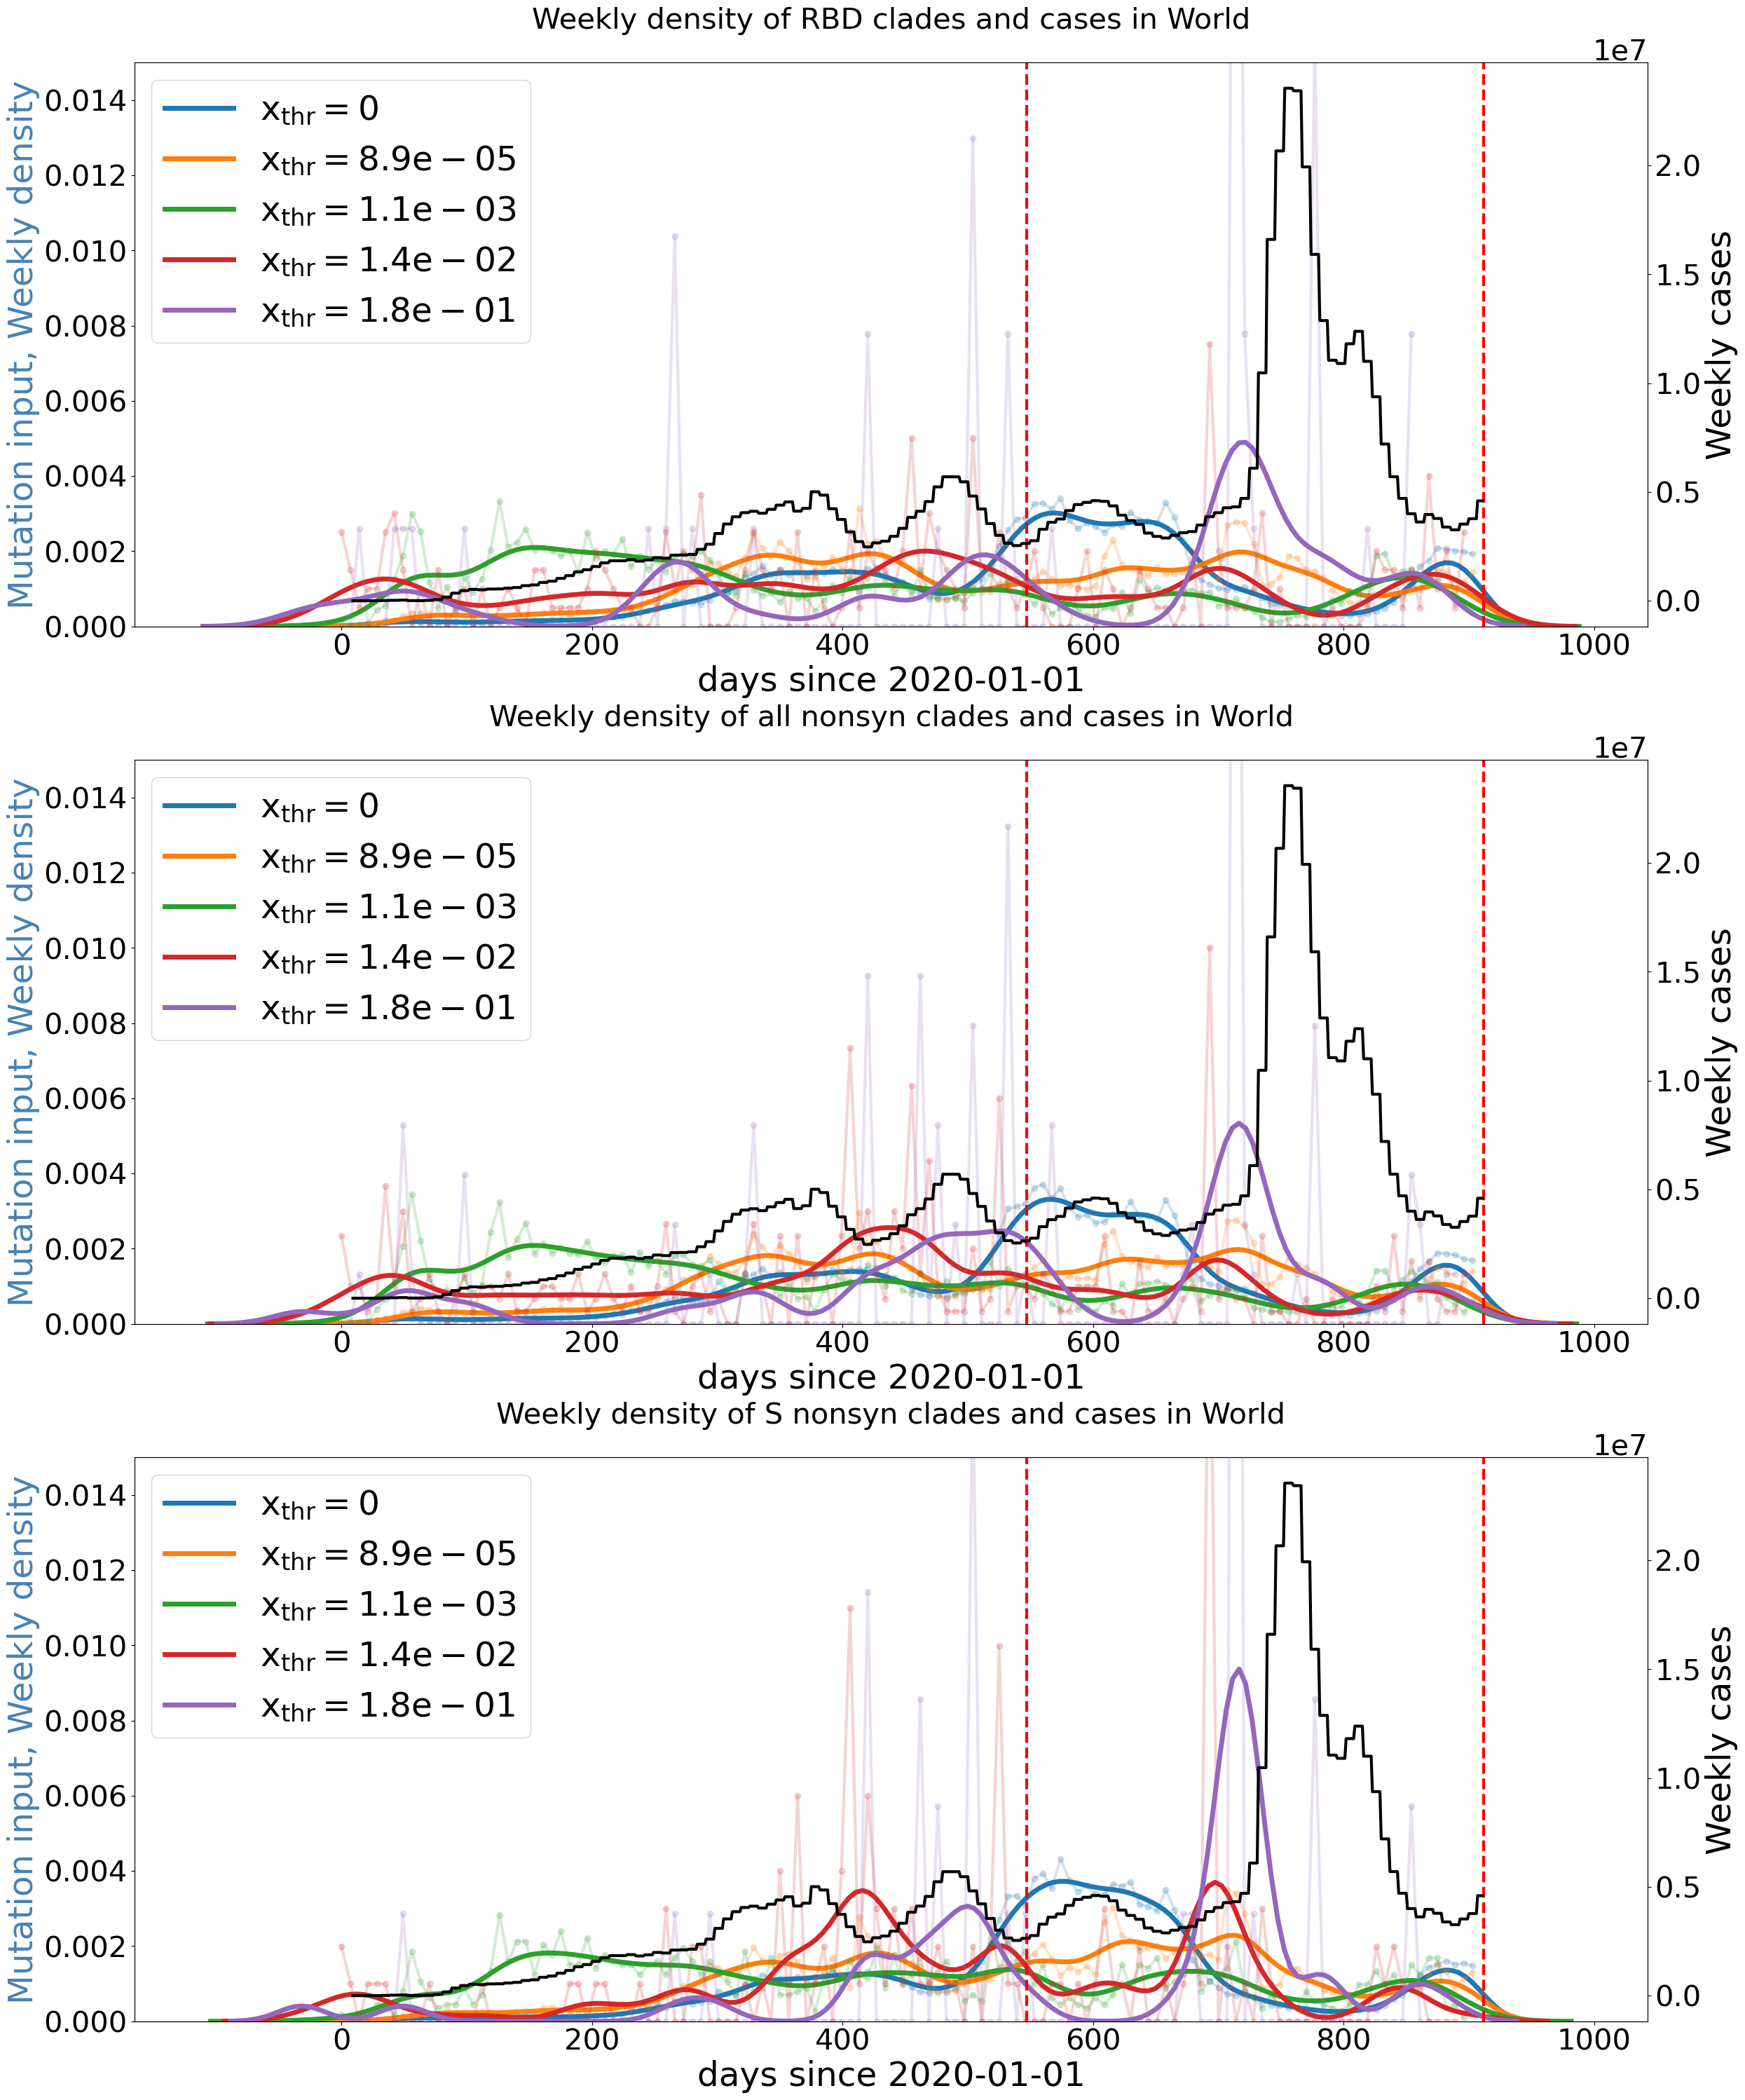

In [150]:
fig,ax= plt.subplots(3,1,figsize=(25,30))

plot_ax0 = True
if plot_ax0:
    b_0, h_0 = np.histogram(syn_x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,syn_x_origination_times['day_diff_0.0e+00'].dt.days.max(),7),density=True)
    l_0, = ax[0].plot(h_0[:-1],b_0, marker='o', alpha=0.2)
    sns.kdeplot(syn_x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color(),ax=ax[0],lw=5)

    for xmin in xmin_vals[9::3]:
        b_xmin,h_xmin = np.histogram(syn_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = np.arange(0,syn_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days.max(),7),density=True)
        l_xmin, = ax[0].plot(h_xmin[:-1],b_xmin, marker='o',alpha=0.2)
        sns.kdeplot(syn_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={xmin:.1e}$',color=l_xmin.get_color(),ax=ax[0],lw=5)
        # ax[0].plot(h_xmin[:-1],b_xmin_smoothed,ls='-',color=l_xmin.get_color())
        # ax[0][0].axvline(x = xmin,color=l_xmin.get_color(), label = fr'$x_\mathrm{{thr}}={xmin:.1e}$')
    ax[0].set_ylim(0,1.5e-2)
    ax[0].legend(loc='best')

    tax0= ax[0].twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax0 ,color='black')
    # mpl_axes_aligner.align.yaxes(ax[0], 0, tax, 0, 0.1)
    ax[0].axvline((pd.to_datetime('2021-07-01')-reference_date).days, color='r',ls='--')
    ax[0].axvline((pd.to_datetime('2022-07-01')-reference_date).days, color='r',ls='--')

    ax[0].set_xlabel(f'days since {reference_date.date()}')
    ax[0].set_ylabel('Mutation input, Weekly density',color='steelblue')

    tax0.set_ylabel('Weekly cases',color='black')
    ax[0].set_title('Weekly density of RBD clades and cases in World', fontsize = 30, y = 1.05)

plot_ax1 = True
if plot_ax1:
    b_0, h_0 = np.histogram(nonsyn_all_x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,nonsyn_all_x_origination_times['day_diff_0.0e+00'].dt.days.max(),7),density=True)
    l_0, = ax[1].plot(h_0[:-1],b_0, marker='o', alpha=0.2)
    sns.kdeplot(nonsyn_all_x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color(),ax=ax[1],lw=5)

    for xmin in xmin_vals[9::3]:
        b_xmin,h_xmin = np.histogram(nonsyn_all_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = np.arange(0,nonsyn_all_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days.max(),7),density=True)
        l_xmin, = ax[1].plot(h_xmin[:-1],b_xmin, marker='o',alpha=0.2)
        sns.kdeplot(nonsyn_all_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={xmin:.1e}$',color=l_xmin.get_color(),ax=ax[1],lw=5)
        # ax[0].plot(h_xmin[:-1],b_xmin_smoothed,ls='-',color=l_xmin.get_color())
        # ax[0][0].axvline(x = xmin,color=l_xmin.get_color(), label = fr'$x_\mathrm{{thr}}={xmin:.1e}$')

    ax[1].set_ylim(0,1.5e-2)
    ax[1].legend(loc='best')

    tax1= ax[1].twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax1 ,color='black')

    ax[1].axvline((pd.to_datetime('2021-07-01')-reference_date).days, color='r',ls='--')
    ax[1].axvline((pd.to_datetime('2022-07-01')-reference_date).days, color='r',ls='--')

    ax[1].set_xlabel(f'days since {reference_date.date()}')
    ax[1].set_ylabel('Mutation input, Weekly density',color='steelblue')

    tax1.set_ylabel('Weekly cases',color='black')
    ax[1].set_title('Weekly density of all nonsyn clades and cases in World', fontsize = 30, y = 1.05)

plot_ax2 = True
if plot_ax2:
    b_0, h_0 = np.histogram(nonsyn_S_x_origination_times['day_diff_0.0e+00'].dt.days,bins = np.arange(0,nonsyn_S_x_origination_times['day_diff_0.0e+00'].dt.days.max(),7),density=True)
    l_0, = ax[2].plot(h_0[:-1],b_0, marker='o', alpha=0.2)
    sns.kdeplot(nonsyn_S_x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color(),ax=ax[2],lw=5)

    for xmin in xmin_vals[9::3]:
        b_xmin,h_xmin = np.histogram(nonsyn_S_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days,bins = np.arange(0,nonsyn_S_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days.max(),7),density=True)
        l_xmin, = ax[2].plot(h_xmin[:-1],b_xmin, marker='o',alpha=0.2)
        sns.kdeplot(nonsyn_S_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={xmin:.1e}$',color=l_xmin.get_color(),ax=ax[2],lw=5)
        # ax[0].plot(h_xmin[:-1],b_xmin_smoothed,ls='-',color=l_xmin.get_color())
        # ax[0][0].axvline(x = xmin,color=l_xmin.get_color(), label = fr'$x_\mathrm{{thr}}={xmin:.1e}$')

    ax[2].set_ylim(0,1.5e-2)
    ax[2].legend(loc='best')

    tax2= ax[2].twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax2 ,color='black')

    ax[2].axvline((pd.to_datetime('2021-07-01')-reference_date).days, color='r',ls='--')
    ax[2].axvline((pd.to_datetime('2022-07-01')-reference_date).days, color='r',ls='--')

    ax[2].set_xlabel(f'days since {reference_date.date()}')
    ax[2].set_ylabel('Mutation input, Weekly density',color='steelblue')

    tax2.set_ylabel('Weekly cases',color='black')
    ax[2].set_title('Weekly density of S nonsyn clades and cases in World', fontsize = 30, y = 1.05)

ax[1].set_xlim(ax[0].get_xlim())
ax[2].set_xlim(ax[0].get_xlim())
plt.tight_layout()


In [129]:
colors_xmin = dict(zip(xmin_vals, sns.color_palette('viridis',len(xmin_vals))))

In [147]:
wt_alpha_crossover_date = pd.to_datetime('2021-03-15')
alpha_delta_crossover_date = pd.to_datetime('2021-06-21')
delta_ba1_crossover_date = pd.to_datetime('2022-01-03')
ba1_ba2_crossover_date = pd.to_datetime('2022-01-31')
ba2_ba5_crossover_date = pd.to_datetime('2022-06-06')
ba5_xbb_crossover_date = pd.to_datetime('2023-02-27')

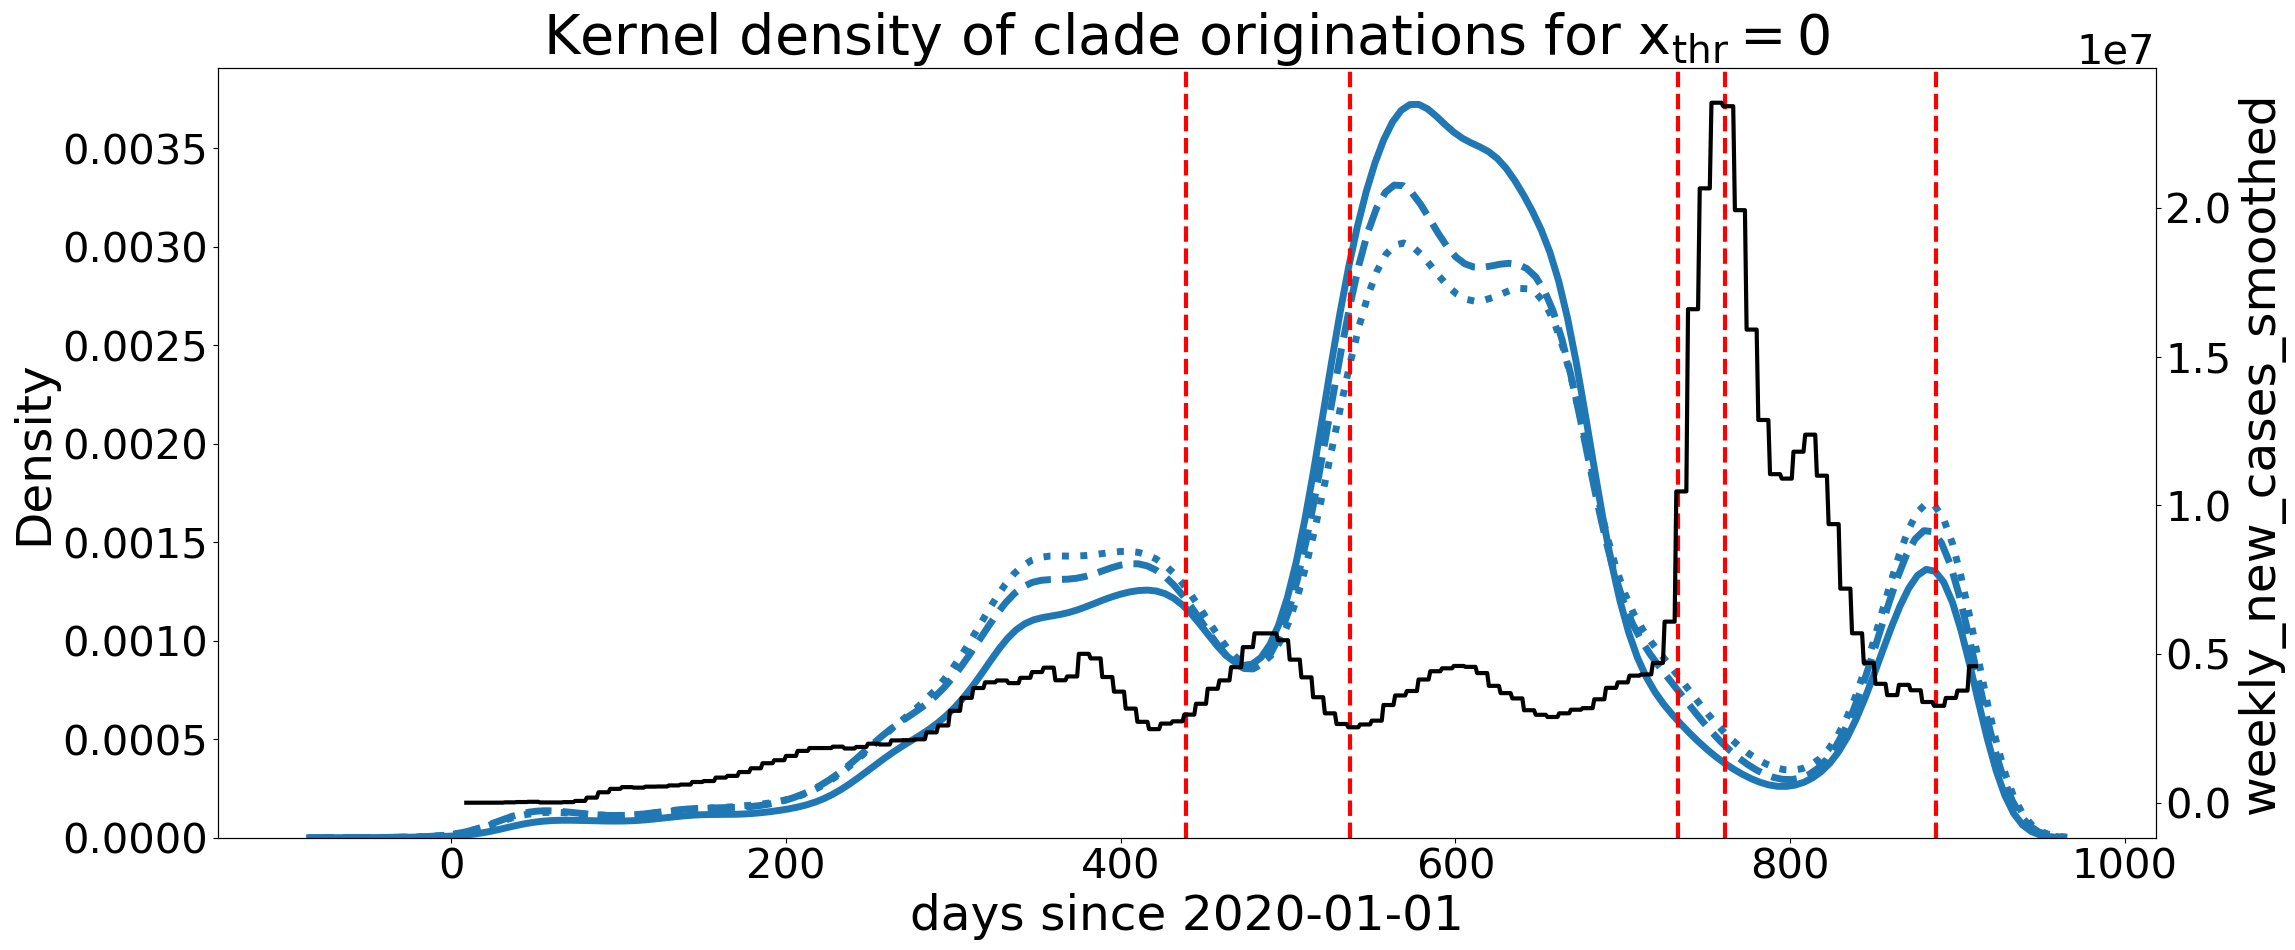

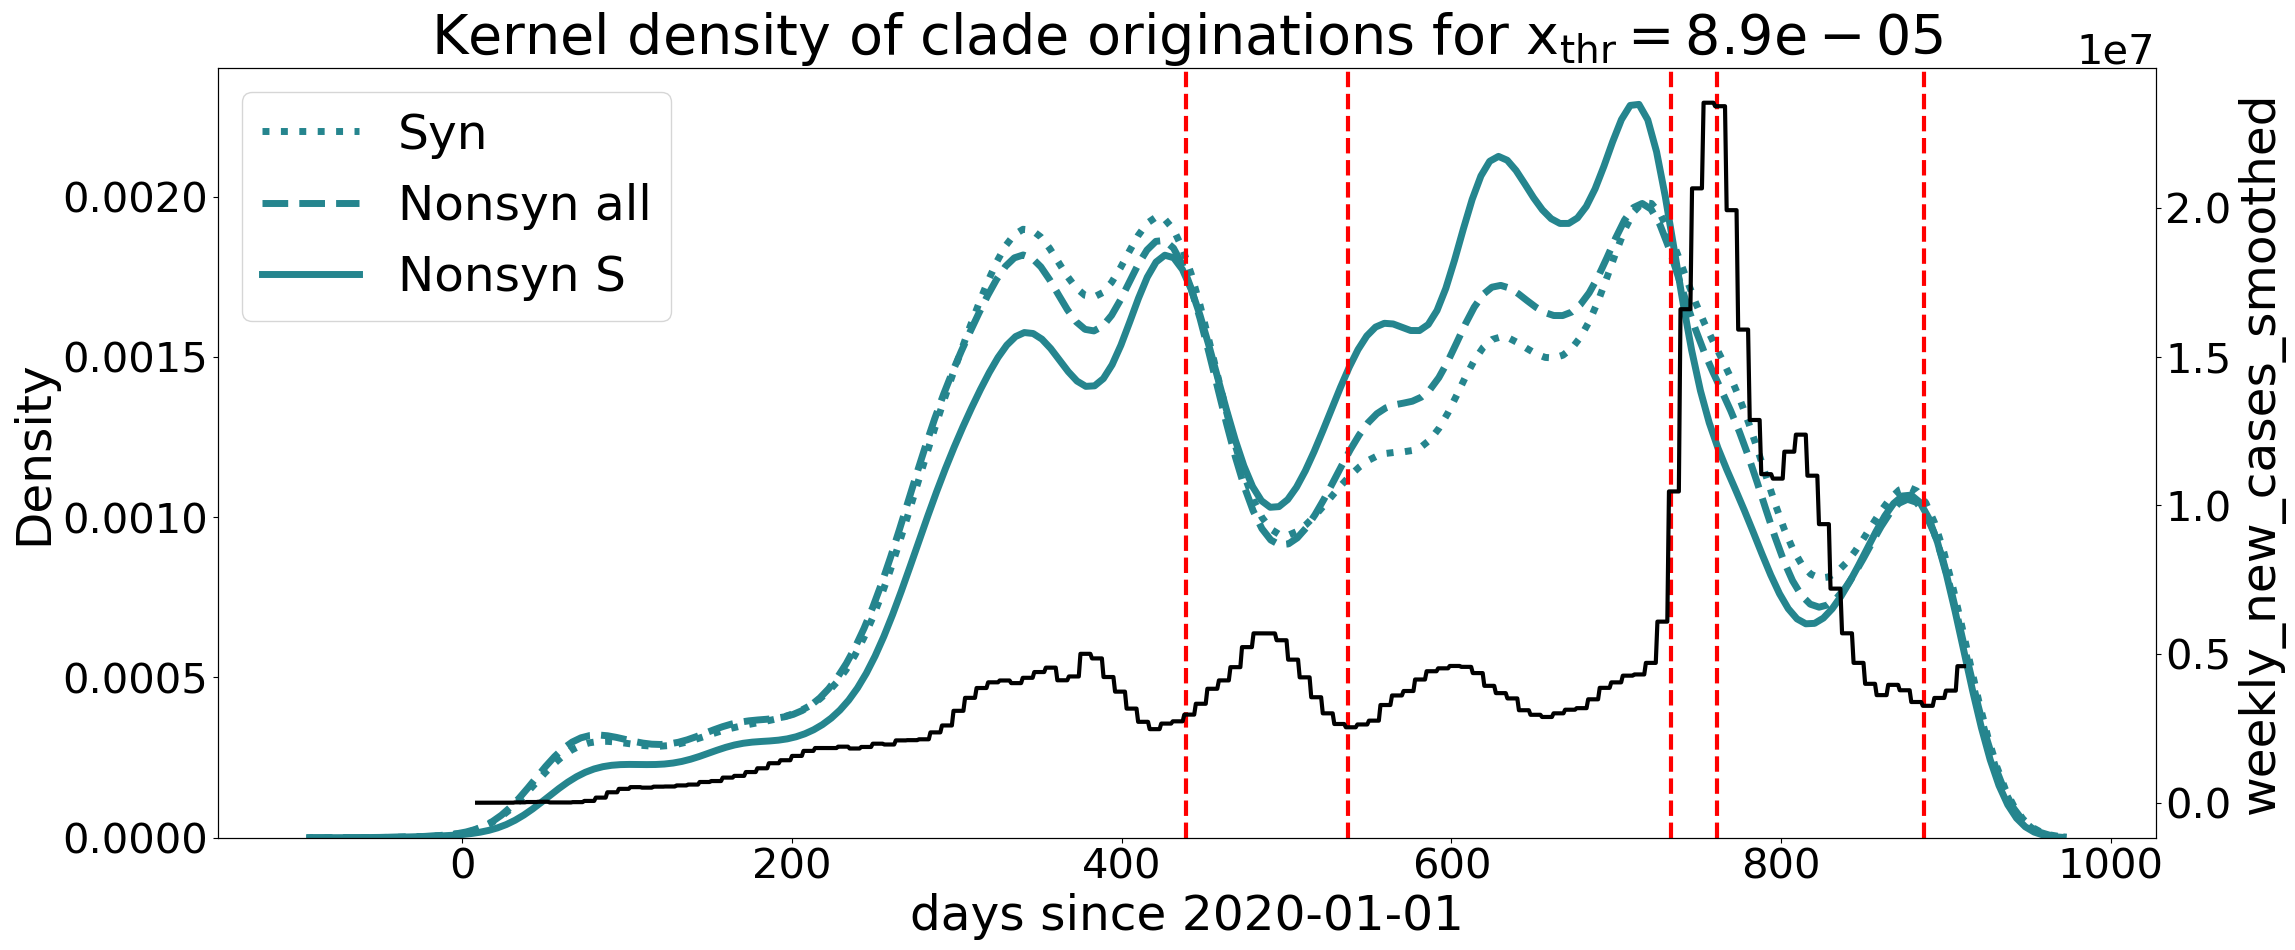

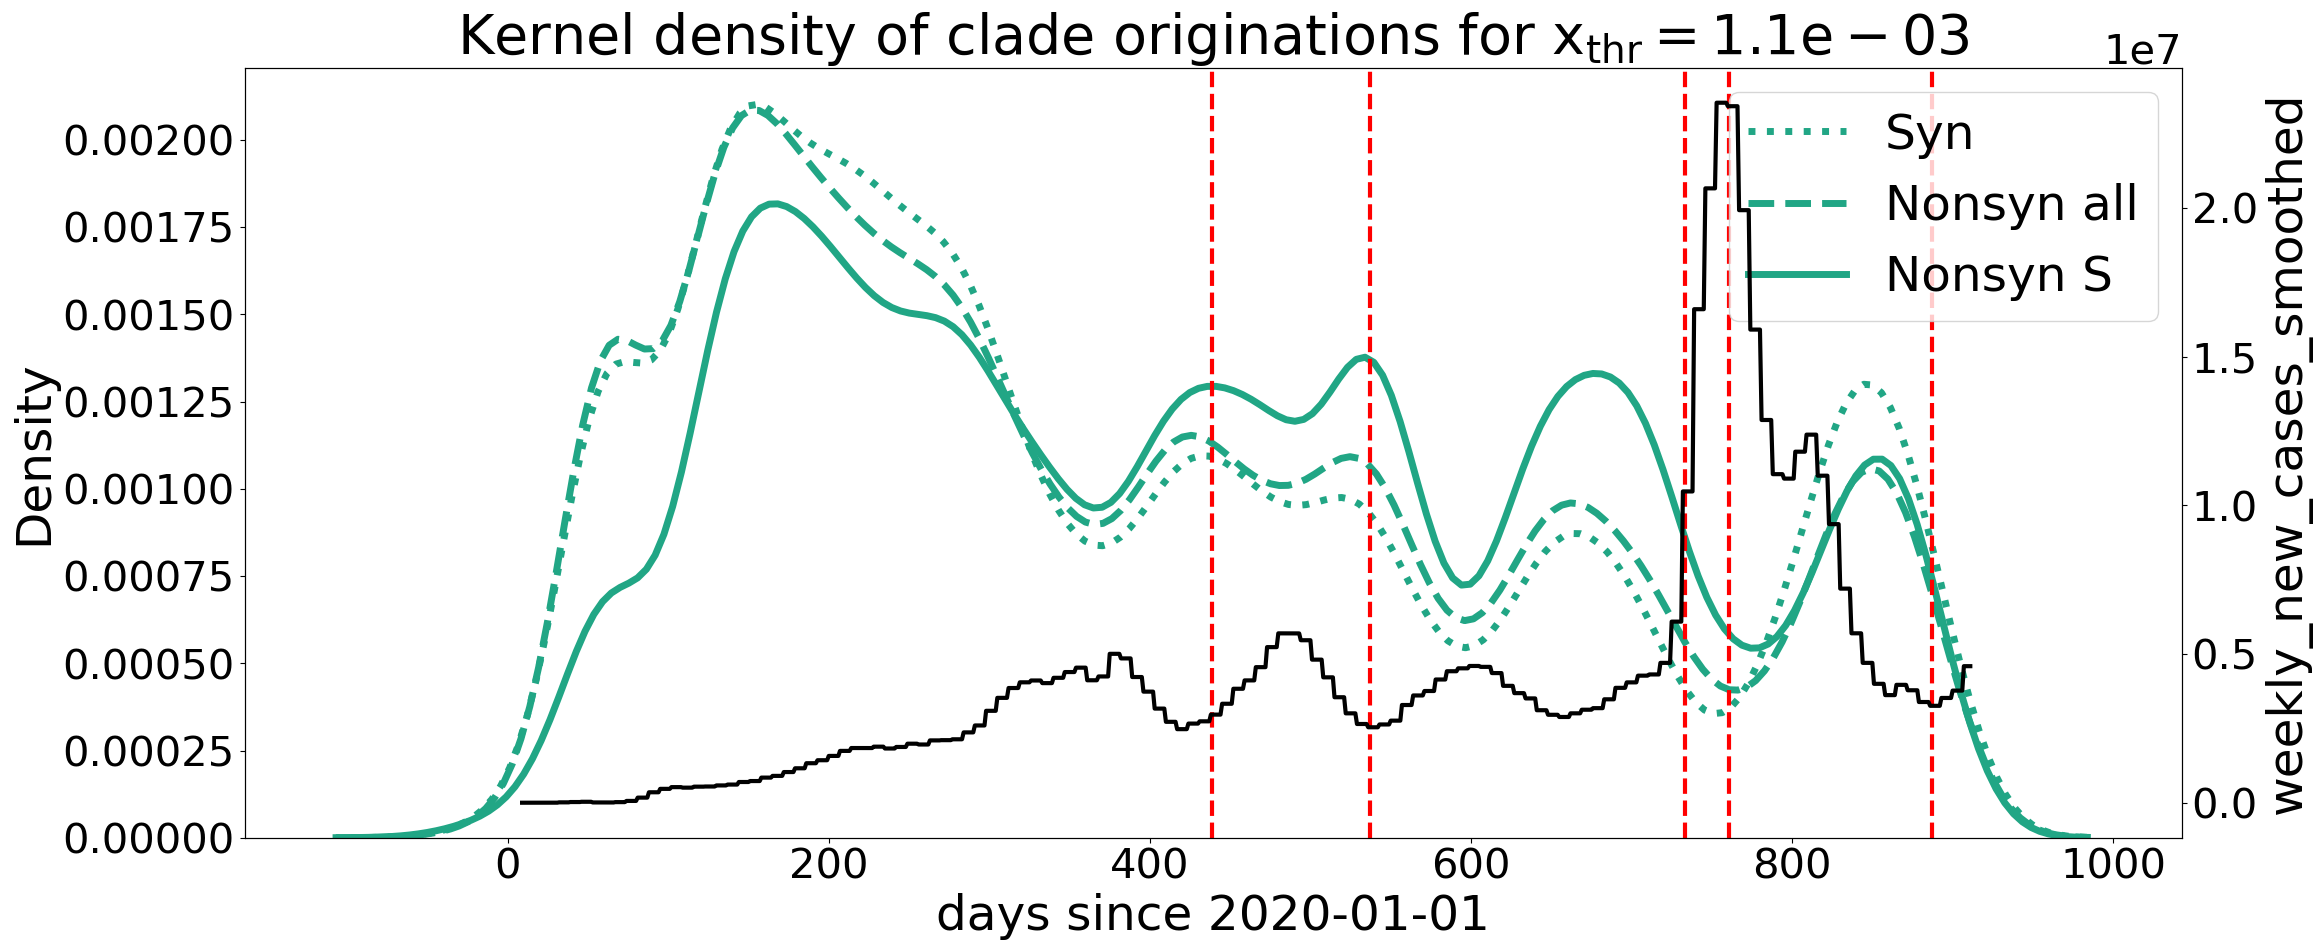

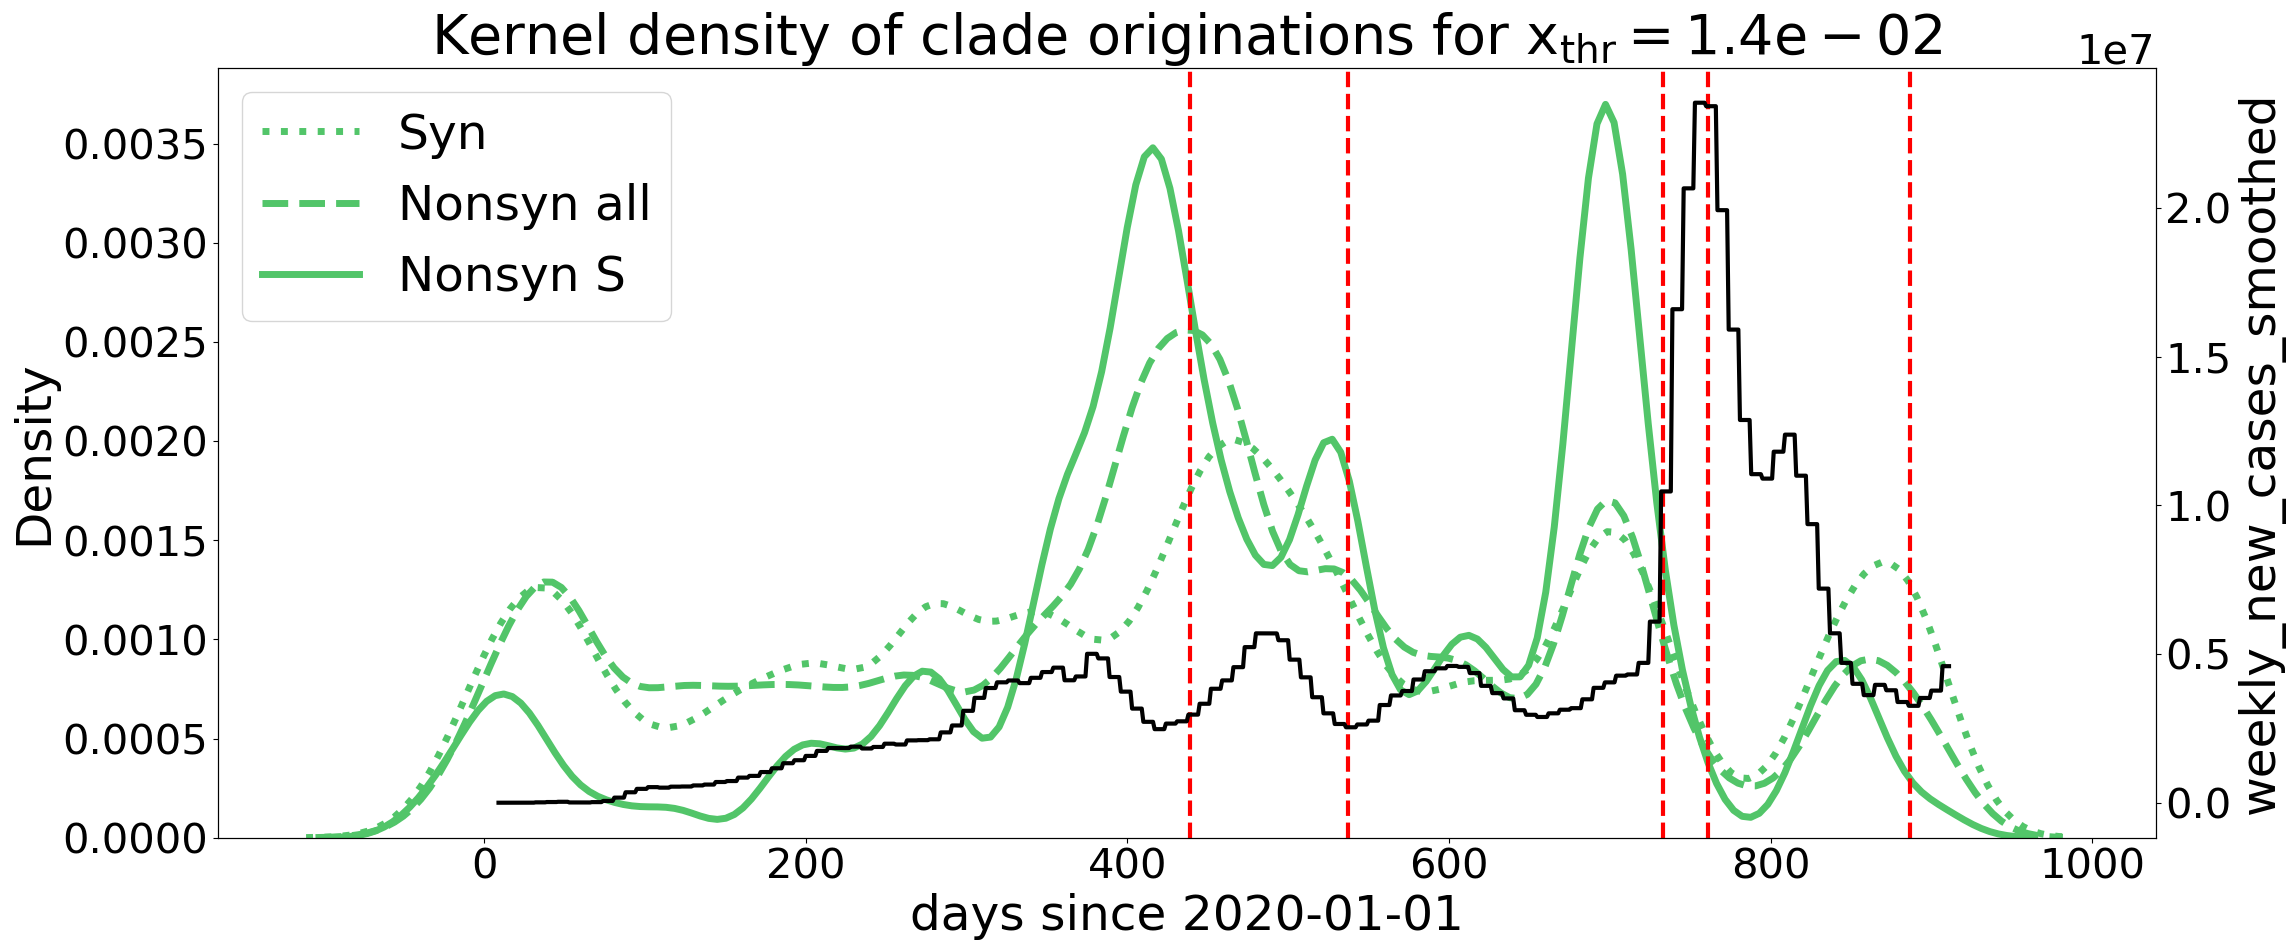

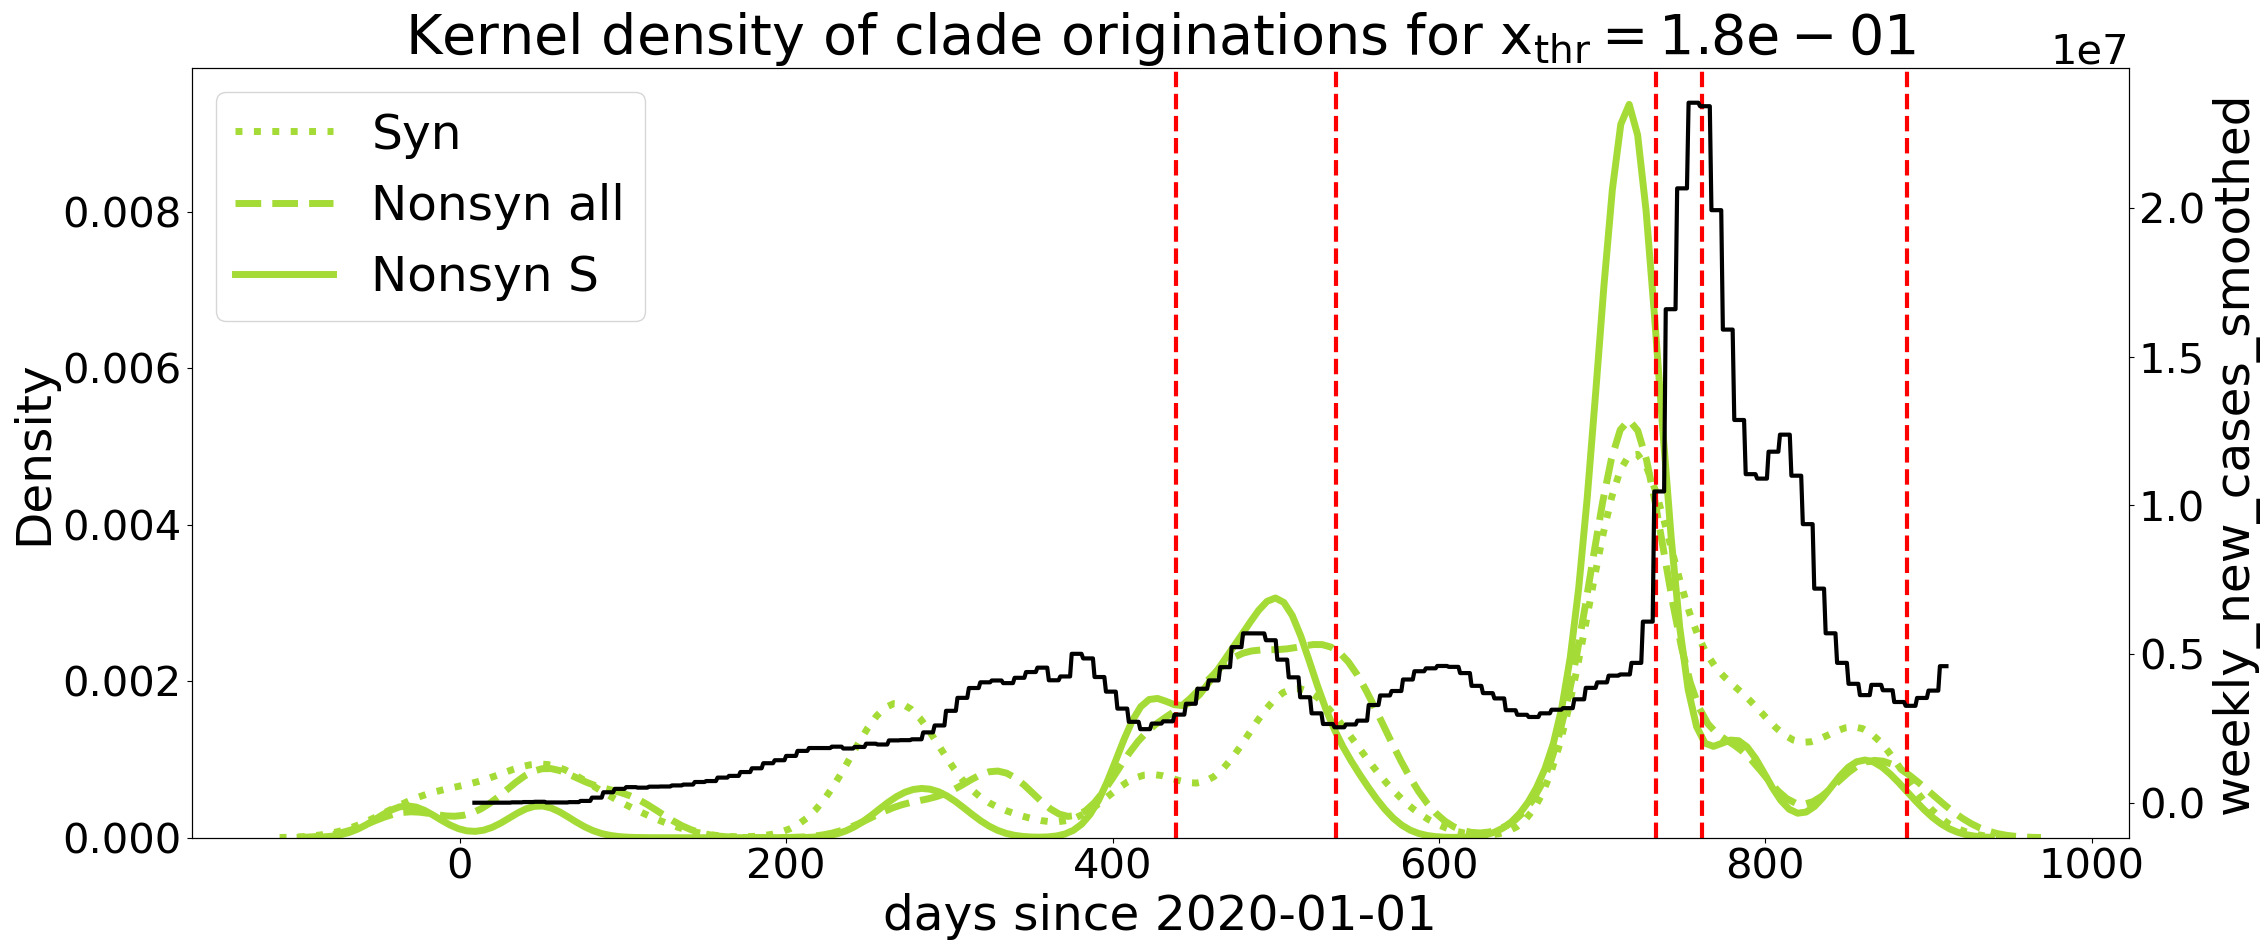

In [149]:
fig,ax= plt.subplots(1,1,figsize=(25,10))
sns.kdeplot(syn_x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color(),ax=ax,lw=5,ls=':')
sns.kdeplot(nonsyn_all_x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color(),ax=ax,lw=5,ls='--')
sns.kdeplot(nonsyn_S_x_origination_times['day_diff_0.0e+00'].dt.days, bw_method=0.1, label = fr'$x_\mathrm{{thr}}={0}$',color=l_0.get_color(),ax=ax,lw=5,ls='-')
ax.set_xlabel(f'days since {reference_date.date()}')
ax.set_title('Kernel density of clade originations for $x_{thr}=0$')
tax = ax.twinx()
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')

for date in [wt_alpha_crossover_date,alpha_delta_crossover_date,delta_ba1_crossover_date,ba1_ba2_crossover_date,ba2_ba5_crossover_date]:
    ax.axvline((date-reference_date).days, color='r',ls='--')

for xmin in xmin_vals[9::3]:
    
    fig,ax= plt.subplots(1,1,figsize=(25,10))
    sns.kdeplot(syn_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1,color=colors_xmin[xmin],ax=ax,lw=5,ls=':',label='Syn')

    sns.kdeplot(nonsyn_all_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1,color=colors_xmin[xmin],ax=ax,lw=5,ls='--',label='Nonsyn all')

    sns.kdeplot(nonsyn_S_x_origination_times[f'day_diff_{xmin:.1e}'].dt.days, bw_method=0.1,
    color=colors_xmin[xmin],ax=ax,lw=5,ls='-',label='Nonsyn S')
    tax = ax.twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
    ax.legend(loc='best')
    ax.set_xlabel(f'days since {reference_date.date()}')
    ax.set_title(f'Kernel density of clade originations for $x_{{thr}}={xmin:.1e}$')
    for date in [wt_alpha_crossover_date,alpha_delta_crossover_date,delta_ba1_crossover_date,ba1_ba2_crossover_date,ba2_ba5_crossover_date]:
        ax.axvline((date-reference_date).days, color='r',ls='--')